# Texture Normal Mapping

## SCC0251.2020.1 - Image Processing

### Prof. Dr. Moacir Ponti

### Renata Vinhaga dos Anjos (10295263) and Vitor Gratiere Torres (10284952)

#### Description

#### How lights are calcultate for surfaces?

Before understanding what is a Normal Map, first we need to describe how Computer Graphics decides the final color for each pixel of a 3D Object. There're a lot of information stored in each vertex, from positions in 3D space to colors. Those vertices build faces, and those faces will have a fragment color, depending of the interpolation of the vertices colors.

But we have to remember that, in the real world, there are a bunch of elements beyond the natural color of a surface that determines it's visual look. One of them is the ligth influence. 

One single light source next to an object will affect the intensity of faces colors, according to each **normal**. Some calculation is done with the light rays, the normal, and the viewer position, as it's demonstrated in the Image below.

![image](https://learnopengl.com/img/lighting/basic_lighting_specular_theory.png)

For our main purpose, is necessary to understand that, each face of a 3D Object has a normal, and as it is flat, all the fragments of this face will be affected in the same way as they have the same normal. Even if it has a complex texture.
With more complex 3D meshes (big ammount of vertices), than the object will have more faces and consequently a bigger variance for the light calculation. But bigger meshes also means more computation, and time is something that needs to be spent wisely in Computer Graphics. 

To solve this problem, we put our efforts in this project to understand how the Normal Map works and how we could implement it.

#### But what are Normal Maps?

The normal map is, as the name implies, a mapping for the normals of a surface. As it is explained in the follow image, instead of having a single normal for all the fragments of a flat surface, what we'll have is a per fragment ("per pixel") diferent normal.

![image](https://learnopengl.com/img/advanced-lighting/normal_mapping_surfaces.png)

The brutal difference for it can be seen in the comparison below:

![image](https://learnopengl.com/img/advanced-lighting/normal_mapping_compare.png)

The geometric normal of the surface remains the same, we merely modify the surface normal used in the lighting equation [11] (as showed before). Just as having a normal per vertex gives the illusion that the surface is smooth between polygons, modifying the normal per pixel changes the perception of the polygon surface itself, without modifying its geometry.
We can see a example of the benefits for it in the image below. The use of a normal map provides that the meshes can be simplified and have the same visual look as a more complex mesh.

![image](https://learnopengl.com/img/advanced-lighting/normal_mapping_comparison.png)


#### The look of a normal map and how it works 

![image](https://docs.unity3d.com/uploads/Main/BumpMapColourMapStoneWallExample.jpg)


#### Implementing the Normal Map from Textures

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [134]:
img = imageio.imread(str(input()).rstrip()) #take a texture, image as input
img = np.asarray(img, dtype = float)

TextureTest.jpg


In [63]:
print(img.shape)
print(img[:,:,[0]].max())
print(img[:,:,[1]].max())
print(img[:,:,[2]].max())
print(img.max())

(640, 640, 3)
255.0
255.0
255.0
255.0


In [64]:
#plt.imshow(img,cmap='gray', vmin=0, vmax=255)

In [65]:
#plt.imshow(img)

In [66]:
# Invert
def inv(img):
    return 255 - img

#### Step 1 - Convert image to Gray Scale
One of the details that we descovered to get better results is that, first we need to convert the texture for a gray scale image (if it is in RGB system). In this way, the range of values is smaller, so the change of them is more visible.

In [162]:
def rgb_img_to_gray(rgb):	
	#if np.array(img.shape) == 3:
			# image isn't greyscale, convert
	gray = np.zeros(np.array(rgb.shape)[0:2])
	r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
# 	gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
	gray = 0.2126 * r + 0.7152 * g + 0.0722 * b
    
# 	print(gray.shape)
# 	print(rgb.shape)
#else:
	return gray

In [163]:
gray_img = rgb_img_to_gray(img)

(-0.5, 358.5, 355.5, -0.5)

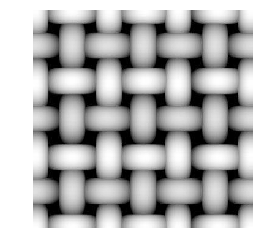

In [164]:
plt.imshow(gray_img,cmap='gray')
plt.axis('off')

In [93]:
#Euclidian Distance between x and y
def E(x, y):
	return np.sqrt(x*x + y*y)

# 1D Gaussian
def G(x, Sigma):
	return (np.exp(-(x * x)/(2 * Sigma * Sigma))/(2 * np.pi * Sigma * Sigma))

#add 0 columms and rows to the matrix m according to the parameter 'add'
def padding(m, add):
	return np.pad(m, [(add, add), (add, add)], mode='constant', constant_values=0)

#remove the added 0 columns and rows
def unpadding(m, sub):
	return m[sub:m.shape[0]-sub, sub:m.shape[1]-sub]

#split a region of the matrix m to apply the filter desired
def cut_region(m,x,y,a,b):
	return m[x-a : x + (a+1), y-b : y+(b+1)];

# Invert
def inv(img):
	return 255 - img

# Return the Spatial Gaussian Kernel 
def Spatial_Gaussian(SigmaS, n):
	a = -int((n-1)/2)
	b = int((n-1)/2)
	Gs = np.zeros((n,n))
	for x in range(a,b + 1):
		for y in range(a,b + 1):
			Gs[x-a][y-a] = G(E(x,y), SigmaS)

	return Gs
# Return the Range Gaussian Kernel 
def Range_Gaussian(m, SigmaR, n):
	a = -int((n-1)/2)
	b = int((n-1)/2)
	center = m[b][b]
	Gs = np.zeros((n,n))
	for x in range(0,n):
		for y in range(0, n):
			Gs[x][y] = G(m[x][y] - center, SigmaR) 
	return Gs

# Intensity
def value(image, c=0, d=255):
	r = image[:,:,0]
	g = image[:,:,1]
	b = image[:,:,2]
	avr = (r + g + b)/3.0
	return avr

In [138]:
# Normalize
def scale1(image, c=0, d=255):
	a = np.min(image)
	b = np.max(image)
	print(a,b,c,d)
	return ((image-a)*((d-c)/(b-a))+c).astype(np.uint8)

def scale_rgb(image, c=0, d=255):
	for i in range(0,2):
		image[:,:,i] = scale1(image[:,:,i],c=c,d=d)
	return image.astype(np.uint8)

In [95]:
# Apply the Bilateral Filter
def smooth_image(I, n, SigmaS, SigmaR):

	N,M = I.shape #dimension of f
	Wp = np.zeros((n,n))
	a = int((n-1)/2)
	b = int((n-1)/2)
	I = padding(I, a)
	If = np.zeros(I.shape)
	Gs = Spatial_Gaussian(SigmaS, n)
	W = 0
	
	for x in range(a, N+1):
		for y in range(b, M+1):
			region = cut_region(I,x,y,a,b)
			Gr = Range_Gaussian(region, SigmaR, n)
			Wp = Gr * Gs
			W = np.sum(Wp)
			If[x,y] = np.sum(np.multiply(Wp, region))
			If[x,y] = If[x,y]/W
			

	I = unpadding(I, a)
	If = unpadding(If, a)

	return If

In [96]:
radius = 3
gammaS = 150.0
gammaR = 100.0

In [97]:
#smoothest_img = smooth_image(gray_img, radius, gammaS, gammaR)

In [98]:
#plt.imshow(smoothest_img,cmap='gray', vmin=0, vmax=255)
#plt.axis('off')

#### Sobel-Feldman operator

Sobel-Feldman operator is an edge detector, it uses two 3×3 kernels which are convolved with the original image to calculate approximations of the derivatives – one for horizontal changes, and one for vertical. If we define $A$ as the source image, and $Gx$ and $Gy$ are two images which at each point contain the vertical and horizontal derivative approximations respectively, the computations are as follows:

$$G_x = \begin{bmatrix}-3 & 0 & 3\\-10 & 0 & 10\\-3 & 0 & 3\end{bmatrix}$$

$$G_y = \begin{bmatrix}-3 & -10 & -3\\0 & 0 & 0\\3 & 10 & 3\end{bmatrix}$$

Then we'll crop $A$ matrix to fit kernel's shape, iterate and convolute it.

> It is also possible to use $G_x$ and $G_y$ with 1s instead of 3s, and 2s instead of 10s, it's just a matter of factors and scales. 3s and 10s got us our best outcome so far.

The x-coordinate is defined here as increasing in the "right"-direction, and the y-coordinate is defined as increasing in the "down"-direction. At each point in the image, the resulting gradient approximations can be combined to give the gradient magnitude, using $G = \sqrt{G_x^2 + G_y^2}$. Using this information, we can also calculate the gradient's direction as $\theta = atan\left(\frac{G_y}{G_x}\right)$, this angle $\theta$ tells us the light's angle, while the $G$ vector is the light's vector itself.

The components $G_x$ and $G_y$ devided by its' square root gives us the unitary components.

The $x$ component will be depicted as our reds, while the $y$ as our greens. Our blue component comes from the height map itself. All of them are scaled to $0-255$. The last operation is to cut through the threshold.

In [166]:
def sobel(img, strength=2.5, level=7.0, threshold=.05):
	Gx = np.array([[-1, 0, 1],
				   [-2, 0, 2],
				   [-1, 0, 1]])
	Gy = np.array([[-1, -2, -1],
				   [0,   0,  0],
				   [1,   2,  1]])
	# Gx = np.array([[-3, 0, 3],
	# 			   [-10, 0, 10],
	# 			   [-3, 0, 3]])
	# Gy = np.array([[-3, -10, -3],
	# 			   [0, 0, 0],
	# 			   [3, 10, 3]])
	
	shp = np.array(img.shape)[0:2]
	img = np.pad(img, 1, 'edge')
	#print(img)
	sob = np.zeros(shp)
	normal_map = np.zeros(np.array([shp[0], shp[1], 3]))
	threshold = int(round(threshold * 255))
	#print(normal_map.shape)
	for i in range(0, shp[0]):
		for j in range(0, shp[1]):
			#print(img[i:i+3, j:j+3])
			            
			dX = np.sum(np.multiply(Gx, img[i:i+3, j:j+3]))
			dY = np.sum(np.multiply(Gy, img[i:i+3, j:j+3]))
			dZ = 1.0 / strength * (1.0 + (2.0 ** level)) #very costly operation!
			sob[i, j] = np.sqrt(dX**2 + dY**2 + dZ**2)
# 			if sob[i,j] < threshold:
# 				sob[i,j] = 0              
# 			normal_map[i, j, 0] = S1 * 0.5 + 0.5
# 			normal_map[i, j, 1] = S2 * 0.5 + 0.5
# 			normal_map[i, j, 2] = 255/2.0
			#if sob[i,j] != 0:
				#normal_map[i, j, 0] = dX/(sob[i,j])  #red channel
				#normal_map[i, j, 1] = dY/(sob[i,j])  #green channel
# 				normal_map[i, j, 0] = dX #red channel
# 				normal_map[i, j, 1] = dY #green channel
# 				normal_map[i, j, 0] = dX/(sob[i,j]) * (sob[i,j] * 0.5) #red channel
# 				normal_map[i, j, 1] = dY/(sob[i,j]) * (sob[i,j] * 0.5)#green channel
			normal_map[i, j, 0] = (dX/sob[i, j] * 0.5 + 0.5) * 255.0 #red
			normal_map[i, j, 1] = (dY/sob[i, j] * 0.5 + 0.5) * 255.0 #green
			normal_map[i, j, 2] = dZ/sob[i, j] * 255.0 # blue
			#else:
			#	normal_map[i,j,0] = 0
			#	normal_map[i,j,1] = 0
			#normal_map[i, j, 2] = 255.0 #blue channel
                    
	print("dX min : ", np.min(normal_map[:,:,0]))
	print("dX max : ", np.max(normal_map[:,:,0]))
	print("dY min : ", np.min(normal_map[:,:,1]))    
	print("dY max : ", np.max(normal_map[:,:,1]))
	sob = scale1(sob)
	#normal_map[:,:,0] = scale(normal_map[:,:,0])
	#normal_map[:,:,1] = scale(normal_map[:,:,1])
	
# 	sob[sob < threshold] = 0
	#normal_map[normal_map < threshold, normal_map < threshold, ] = 0
	return normal_map, sob

In [167]:
normal_map, sob = sobel(gray_img)

dX min :  0.8414181994298722
dX max :  254.10409186323824
dY min :  0.8649453168919063
dY max :  254.31458258208366
51.6 498.6808197635036 0 255


In [168]:
# normal_map_scaled_1 = scale_rgb(normal_map,c=77,d=177)
normal_map_scaled_1 = scale_rgb(normal_map)
#print(normal_map_scaled_1)
#normal_map_scaled_1[:,:,0] = inv(normal_map_scaled_1[:,:,0])

0.8414181994298722 254.10409186323824 0 255
0.8649453168919063 254.31458258208366 0 255


(-0.5, 358.5, 355.5, -0.5)

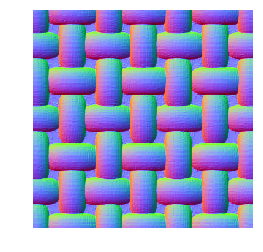

In [169]:
plt.imshow(normal_map_scaled_1)
plt.axis('off')

In [127]:
imageio.imwrite('reva_normal3.png', normal_map_scaled_1)

In [103]:
print(normal_map_scaled_1[:,:,0])
print(normal_map_scaled_1[:,:,1])
print(normal_map_scaled_1[:,:,2])

[[121. 121. 121. ... 121. 121. 121.]
 [121. 121. 121. ... 121. 121. 121.]
 [121. 121. 121. ... 121. 121. 121.]
 ...
 [121. 121. 121. ... 121. 121. 121.]
 [121. 121. 121. ... 121. 121. 121.]
 [121. 121. 121. ... 121. 121. 121.]]
[[128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]
 ...
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(-0.5, 639.5, 639.5, -0.5)

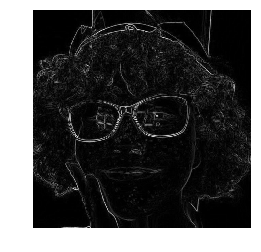

In [104]:
plt.imshow(sob,cmap='gray', vmin=0, vmax=255)
plt.axis('off')

#### These are the RGB channels

(-0.5, 358.5, 355.5, -0.5)

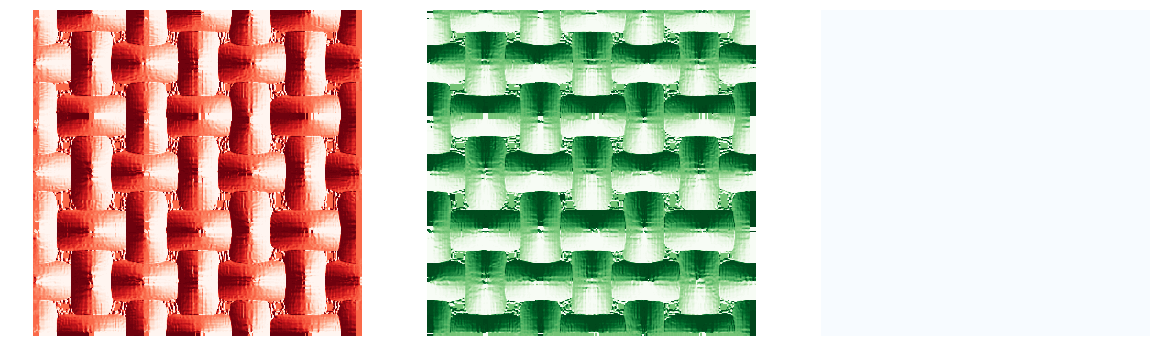

In [161]:
plt.figure(figsize=(20, 20))

plt.subplot(131)
plt.imshow(normal_map_scaled_1[:,:,0], cmap = "Reds")
plt.axis('off')

plt.subplot(132)
plt.imshow(normal_map_scaled_1[:,:,1], cmap = "Greens")
plt.axis('off')

plt.subplot(133)
plt.imshow(normal_map_scaled_1[:,:,2], cmap = "Blues")
plt.axis('off')

-> Now, the goal is to improve the edge detection, making the edges more tiny and robust with the Canny Edge Detection


-> Explain tangent maps and why Sobel Operator Works


-> Canny Edges uses Sobel Operator in its process

#### Bibliography

##### Normal Map

[1] https://en.wikipedia.org/wiki/Lambertian_reflectance

[2] https://cpetry.github.io/NormalMap-Online/

[3] https://www.quora.com/How-are-normal-maps-made

[4] https://stackoverflow.com/questions/13983189/opengl-how-to-calculate-normals-in-a-terrain-height-grid/13983431#13983431

[5] https://en.wikipedia.org/wiki/Von_Neumann_neighborhood

[6] https://azgaar.wordpress.com/2018/02/26/image-converter/

[7] https://en.wikipedia.org/wiki/Sobel_operator

[8] http://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm

[9] https://docs.unity3d.com/Manual/StandardShaderMaterialParameterNormalMap.html

[10] K. Engel (2006). Real-time volume graphics.

[11] Moller, Haines and Naty. Real-Time Rendering (Third Edition)

##### Bump Map

https://web.archive.org/web/20060924191232/http://freespace.virgin.net/hugo.elias/graphics/x_polybm.htm

##### Canny Edge Detection
https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

https://towardsdatascience.com/implement-canny-edge-detection-from-scratch-with-pytorch-a1cccfa58bed

https://www.researchgate.net/publication/258225507_Edge_Detection_on_Polynomial_Texture_Maps

https://en.wikipedia.org/wiki/Canny_edge_detector

##### Edge Detection

https://en.wikipedia.org/wiki/Edge_detection